In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# eda on data -> build models -> isolation forest , Local Outlier Factor (LOF) , xgboost , lightgbm -> mlflow, dvc -> streamlit app

In [3]:
df = pd.read_csv('../paySim/PaySim_log.csv')
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [4]:
df.shape

(6362620, 11)

In [5]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

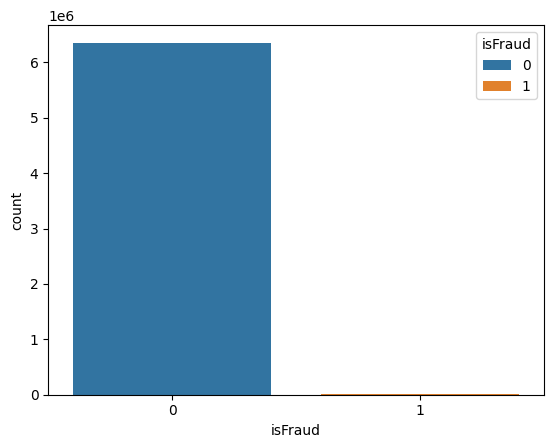

In [8]:
sns.countplot(x='isFraud', data=df, hue='isFraud')
plt.show()

In [9]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [10]:
print(df['type'].value_counts())
transaction_types = df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


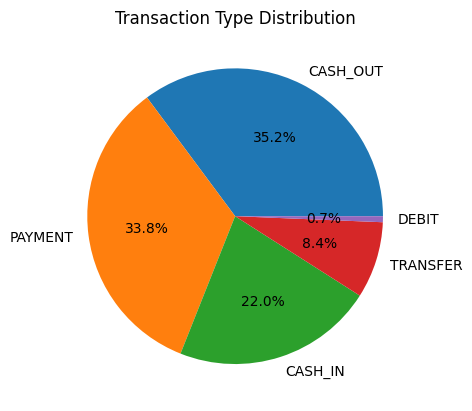

In [11]:
plt.pie(transaction_types.values, labels=transaction_types.index, autopct='%1.1f%%') # type: ignore
plt.title('Transaction Type Distribution')
plt.show()


In [12]:
df.groupby('type')['isFraud'].mean().sort_values(ascending=False)

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

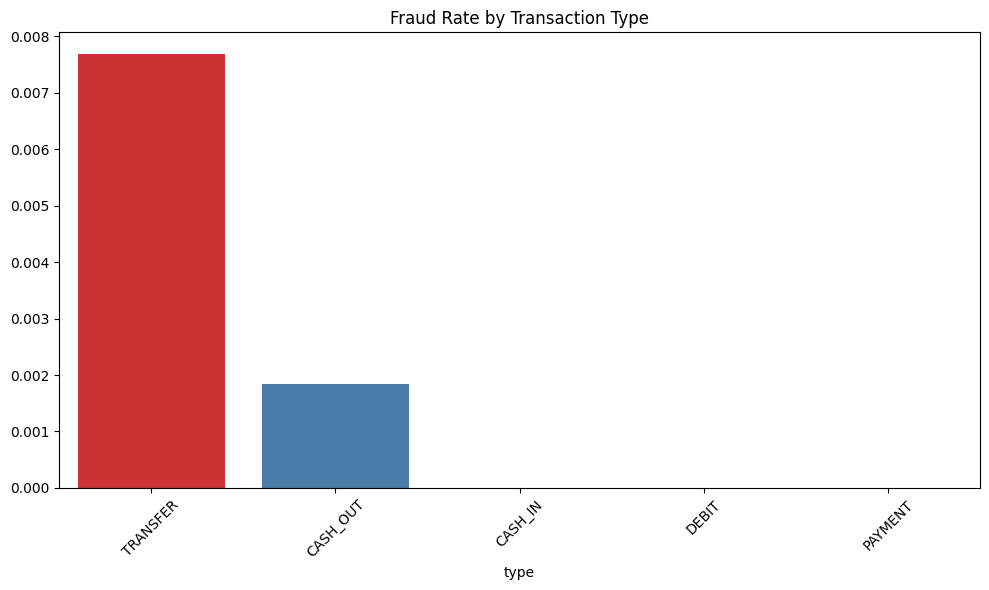

In [13]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, hue=fraud_by_type.index,palette='Set1')
plt.title('Fraud Rate by Transaction Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
df['hour'] = df['step'] % 24
df['day'] = (df['step'] // 24) % 7
df['is_weekend'] = (df['day'] >= 5).astype(int)
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  hour  \
0  M1979787155             0.0             0.0        0               0     1   
1  M2044282225             0.0             0.0        0               0     1   
2   C553264065             0.0             0.0        1               0     1   
3    C38997010         21182.0             0.0        1               0     1   
4  M1230701703             0.0             0.0        0               0     1   

   day  is_weekend  
0    0           0  
1    0           0  
2    0           0  
3    0           0  
4    0           0

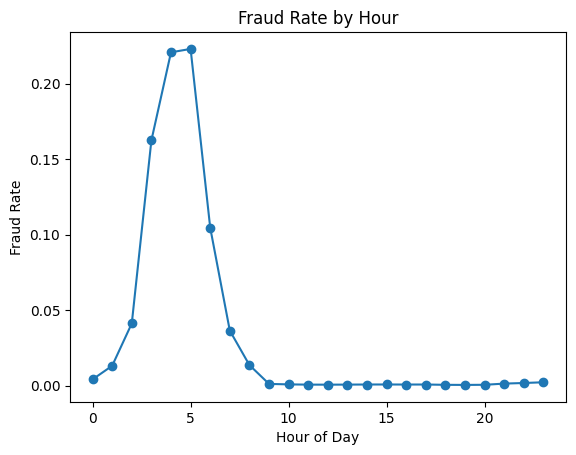

In [15]:
fraud_by_hour = df.groupby('hour')['isFraud'].mean()
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o') # type: ignore
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Hour')
plt.show()

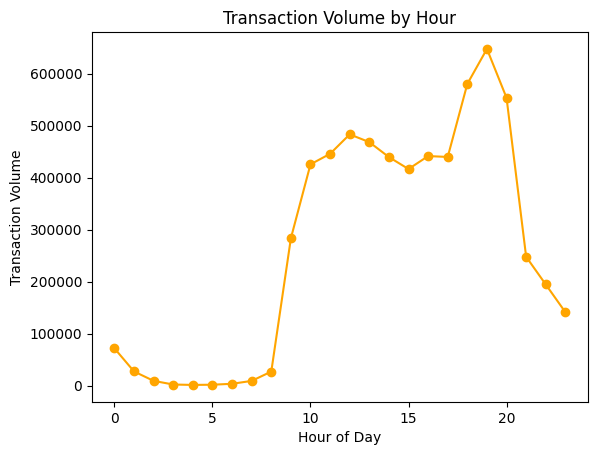

In [16]:
volume_by_hour = df.groupby('hour').size()
plt.plot(volume_by_hour.index, volume_by_hour.values, marker='o', color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Volume')
plt.title('Transaction Volume by Hour')
plt.show()

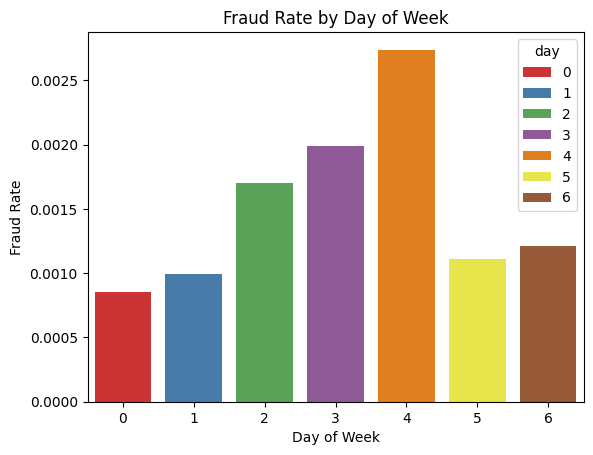

In [17]:
fraud_by_day = df.groupby('day')['isFraud'].mean()
sns.barplot(x = fraud_by_day.index, y = fraud_by_day.values, hue=fraud_by_day.index, palette = 'Set1') # type: ignore
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Day of Week')
plt.show()

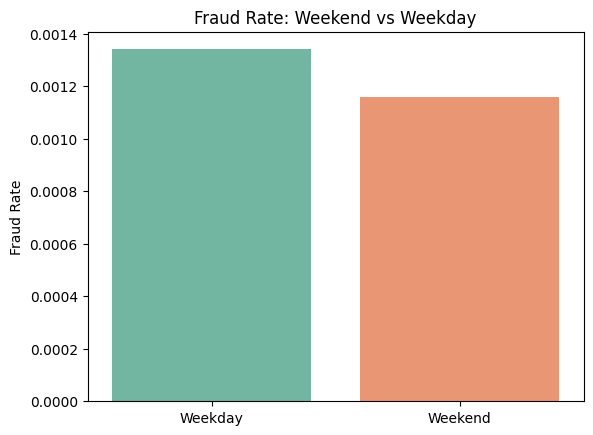

In [18]:
fraud_weekend = df.groupby('is_weekend')['isFraud'].mean()
sns.barplot(x = ['Weekday', 'Weekend'], y = fraud_weekend.values, hue=['Weekday', 'Weekend'], palette = 'Set2') # type: ignore
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate: Weekend vs Weekday')
plt.show()

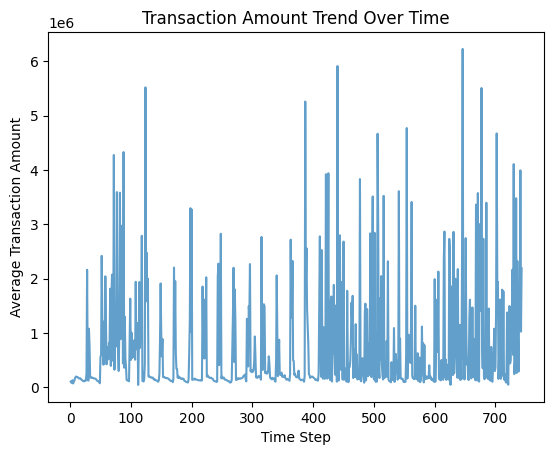

In [19]:
amount_by_step = df.groupby('step')['amount'].mean()
plt.plot(amount_by_step.index, amount_by_step.values, alpha=0.7) # type: ignore
plt.xlabel('Time Step')
plt.ylabel('Average Transaction Amount')
plt.title('Transaction Amount Trend Over Time')
plt.show()

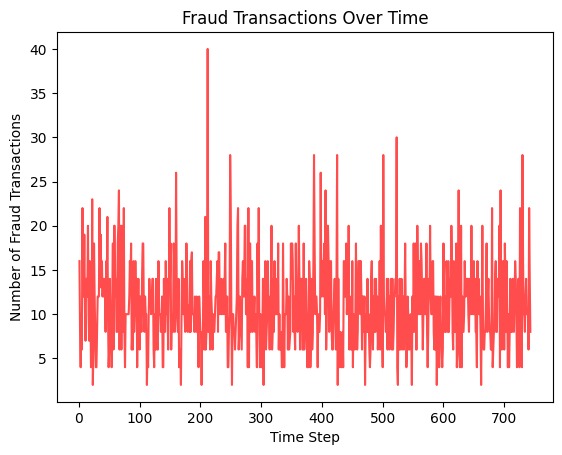

In [20]:
fraud_transactions = df[df['isFraud'] == 1]
fraud_by_step = fraud_transactions.groupby('step').size()
plt.plot(fraud_by_step.index, fraud_by_step.values, color='red', alpha=0.7) # type: ignore
plt.xlabel('Time Step')
plt.ylabel('Number of Fraud Transactions')
plt.title('Fraud Transactions Over Time')
plt.show()

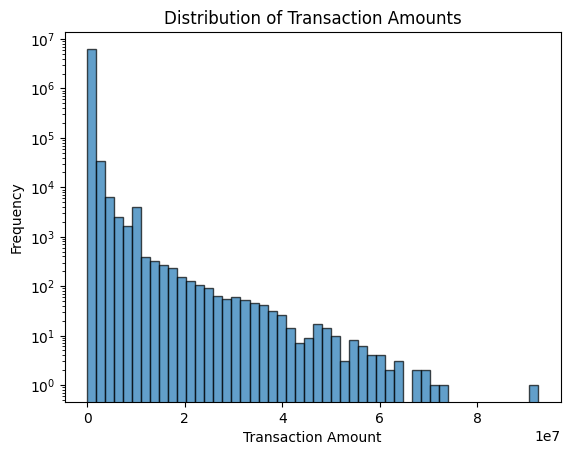

In [21]:
plt.hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts')
plt.yscale('log')
plt.show()

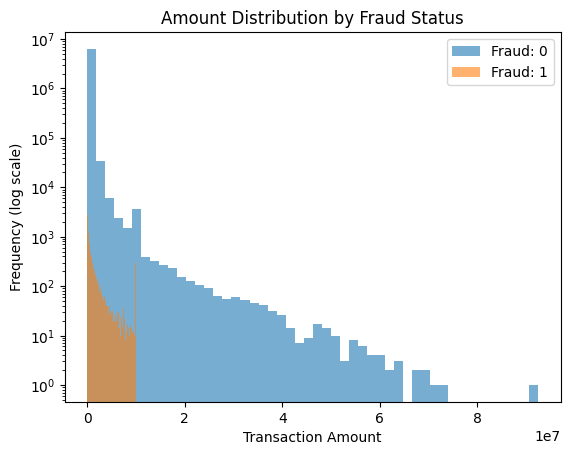

In [22]:
for fraud_status in [0, 1]:
    subset = df[df['isFraud'] == fraud_status]
    plt.hist(subset['amount'], bins=50, alpha=0.6, 
             label=f'Fraud: {fraud_status}', log=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (log scale)')
plt.title('Amount Distribution by Fraud Status')
plt.legend()

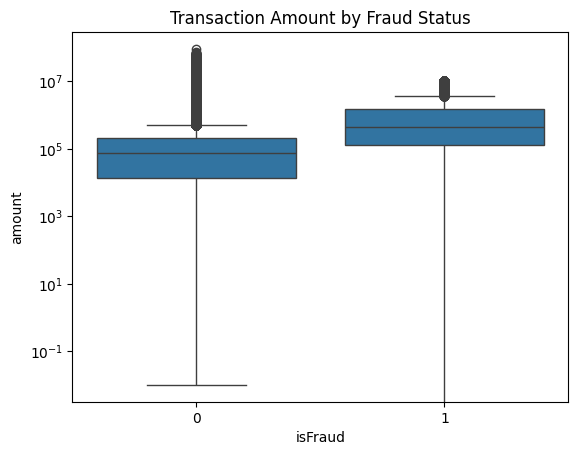

In [23]:
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')
plt.title('Transaction Amount by Fraud Status')
plt.show()

In [24]:
top_transactions = df.nlargest(100, 'amount')
sns.scatterplot(x='step', y='amount', hue='isFraud', data=top_transactions)
plt.title('Top 100 Largest Transactions')
plt.ylabel('Amount')
plt.show()

In [25]:
fraud_stats = df.groupby('isFraud')['amount'].agg(['mean', 'median', 'std', 'min', 'max'])
fraud_stats.plot(kind='bar', subplots=True, layout=(2, 3), figsize=(15, 10))
plt.tight_layout()


In [26]:
for fraud_status in [0, 1]:
    subset = df[df['isFraud'] == fraud_status]['amount']
    plt.hist(subset, bins=1000, cumulative=True, density=True, 
             histtype='step', alpha=0.8, label=f'Fraud: {fraud_status}')
plt.xscale('log')
plt.xlabel('Transaction Amount (log scale)')
plt.ylabel('CDF')
plt.title('Cumulative Distribution of Amounts')
plt.legend()

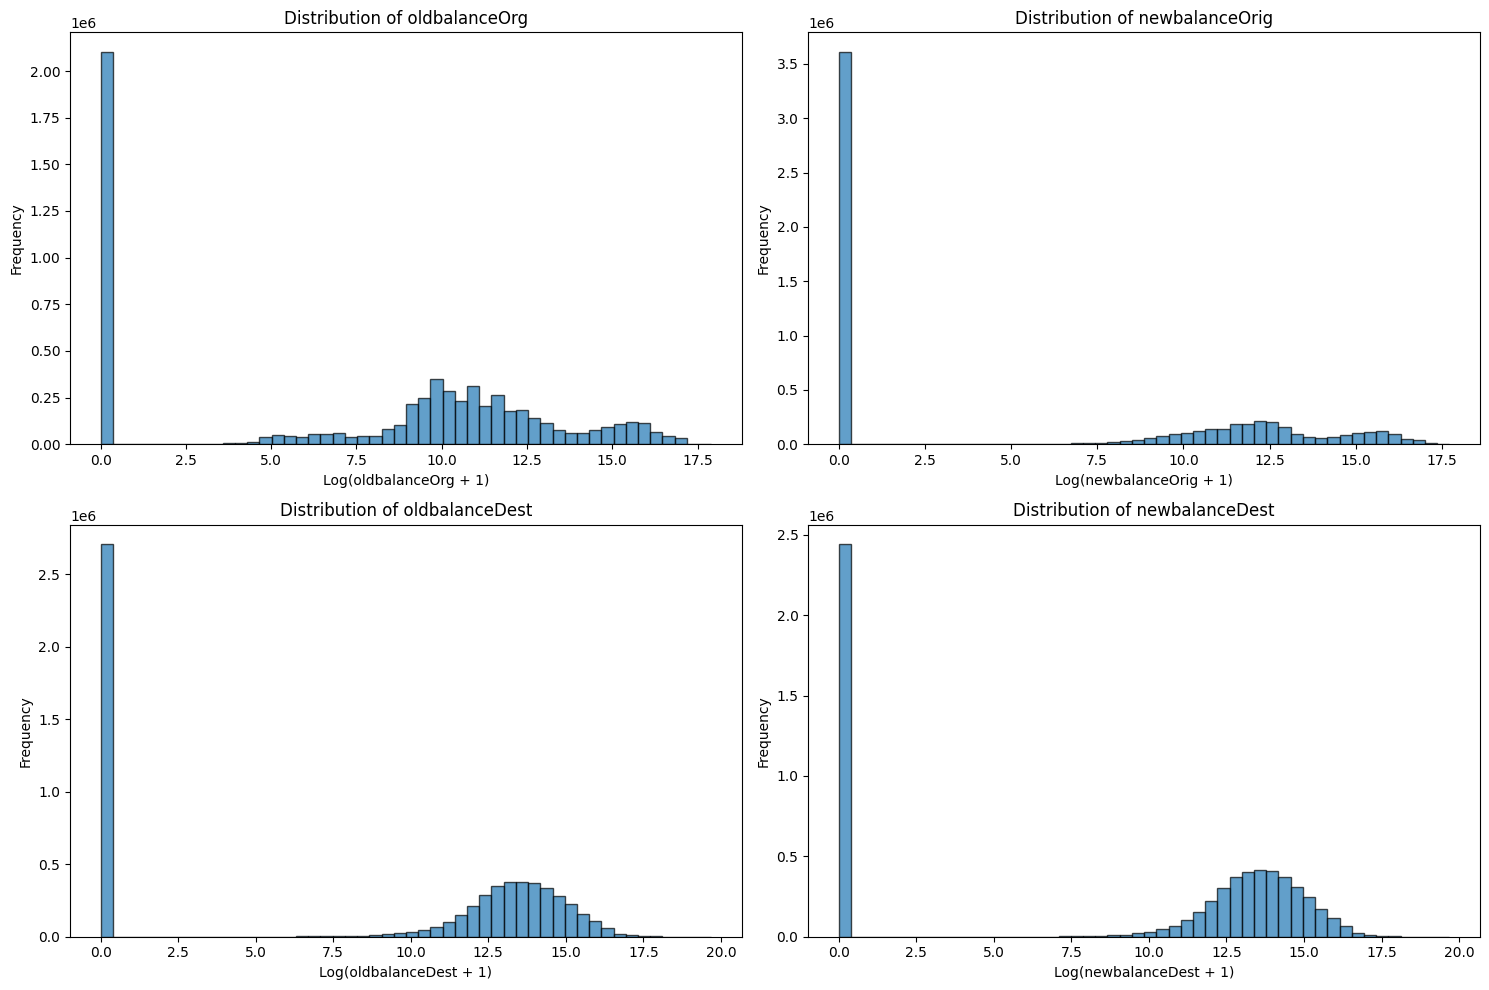

In [27]:
# Balance features analysis
balance_features = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(balance_features, 1):
    plt.subplot(2, 2, i)
    plt.hist(np.log1p(df[feature]), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel(f'Log({feature} + 1)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [28]:
df['balance_change_org'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='isFraud', y='balance_change_org', data=df)
plt.title('Originator Balance Change by Fraud Status')

plt.subplot(1, 2, 2)
sns.boxplot(x='isFraud', y='balance_change_dest', data=df)
plt.title('Destination Balance Change by Fraud Status')

plt.tight_layout()
plt.show()

In [29]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  hour  \
0  M1979787155             0.0             0.0        0               0     1   
1  M2044282225             0.0             0.0        0               0     1   
2   C553264065             0.0             0.0        1               0     1   
3    C38997010         21182.0             0.0        1               0     1   
4  M1230701703             0.0             0.0        0               0     1   

   day  is_weekend  balance_change_org  balance_change_dest  
0    0           0            -9839.64                  0.0  
1    0           0            -1864.28                  0.0  
2    0           0             -181.00                  0.0  
3    0           0             -181.00             -21182.0  
4    0           0           -11668.14                  0.0

In [30]:
customer_orig_stats = df.groupby('nameOrig').agg({
    'amount': ['count', 'mean', 'std', 'sum'],
    'isFraud': 'mean'
}).round(2)

customer_dest_stats = df.groupby('nameDest').agg({
    'amount': ['count', 'mean', 'std', 'sum'],
    'isFraud': 'mean'
}).round(2)

In [31]:
print("Top 10 Originators by Transaction Count:")
print(customer_orig_stats.nlargest(10, ('amount', 'count'))) # type: ignore

print("\nTop 10 Destinations by Transaction Count:")
print(customer_dest_stats.nlargest(10, ('amount', 'count'))) # type: ignore

Top 10 Originators by Transaction Count:
            amount                                  isFraud
             count       mean        std        sum    mean
nameOrig                                                   
C1065307291      3   37826.43   44223.77  113479.28     0.0
C1462946854      3   55597.14   50311.77  166791.43     0.0
C1530544995      3  163511.70  153710.63  490535.09     0.0
C1677795071      3   81578.46  125605.04  244735.38     0.0
C1784010646      3  145566.75  192078.17  436700.25     0.0
C1832548028      3  104555.28   81378.30  313665.83     0.0
C1902386530      3  254570.93  228772.41  763712.79     0.0
C1976208114      3  170376.78  168428.37  511130.35     0.0
C1999539787      3   96851.67  126486.69  290555.01     0.0
C2051359467      3   29771.12   11485.61   89313.36     0.0

Top 10 Destinations by Transaction Count:
            amount                                       isFraud
             count        mean         std           sum    mean
nameDe

In [32]:
transaction_counts_orig = df['nameOrig'].value_counts()
plt.hist(transaction_counts_orig, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Transactions per Originator')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions per Originator')
plt.yscale('log')
plt.show()

In [33]:
transaction_counts_dest = df['nameDest'].value_counts()
plt.hist(transaction_counts_dest, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Transactions per Destination')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions per Destination')
plt.yscale('log')
plt.show()

C:\Users\Ann\AppData\Local\Temp\ipykernel_16960\1506885580.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_activity = df.groupby(activity_bins)['isFraud'].mean()


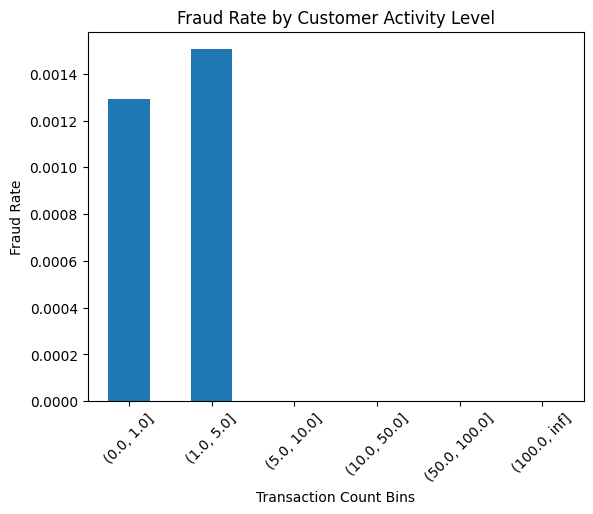

In [34]:
df['orig_txn_count'] = df.groupby('nameOrig')['nameOrig'].transform('count')
activity_bins = pd.cut(df['orig_txn_count'], bins=[0, 1, 5, 10, 50, 100, float('inf')])
fraud_by_activity = df.groupby(activity_bins)['isFraud'].mean()
fraud_by_activity.plot(kind='bar')
plt.xlabel('Transaction Count Bins')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Customer Activity Level')
plt.xticks(rotation=45)
plt.show()

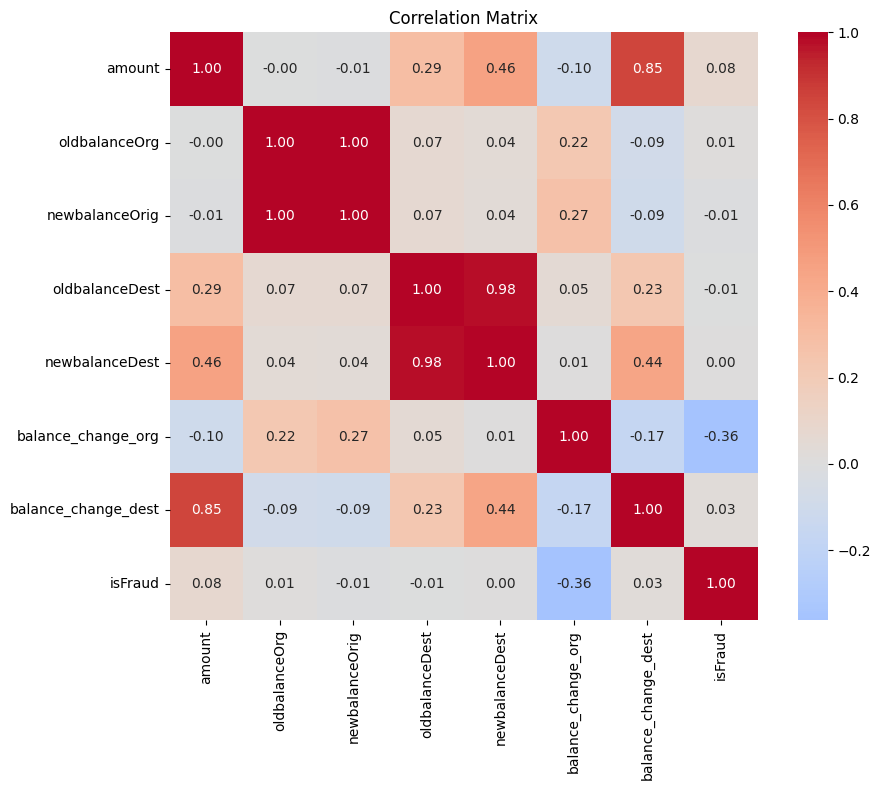

In [35]:
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                   'oldbalanceDest', 'newbalanceDest', 'balance_change_org', 
                   'balance_change_dest']
correlation_matrix = df[numeric_features + ['isFraud']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

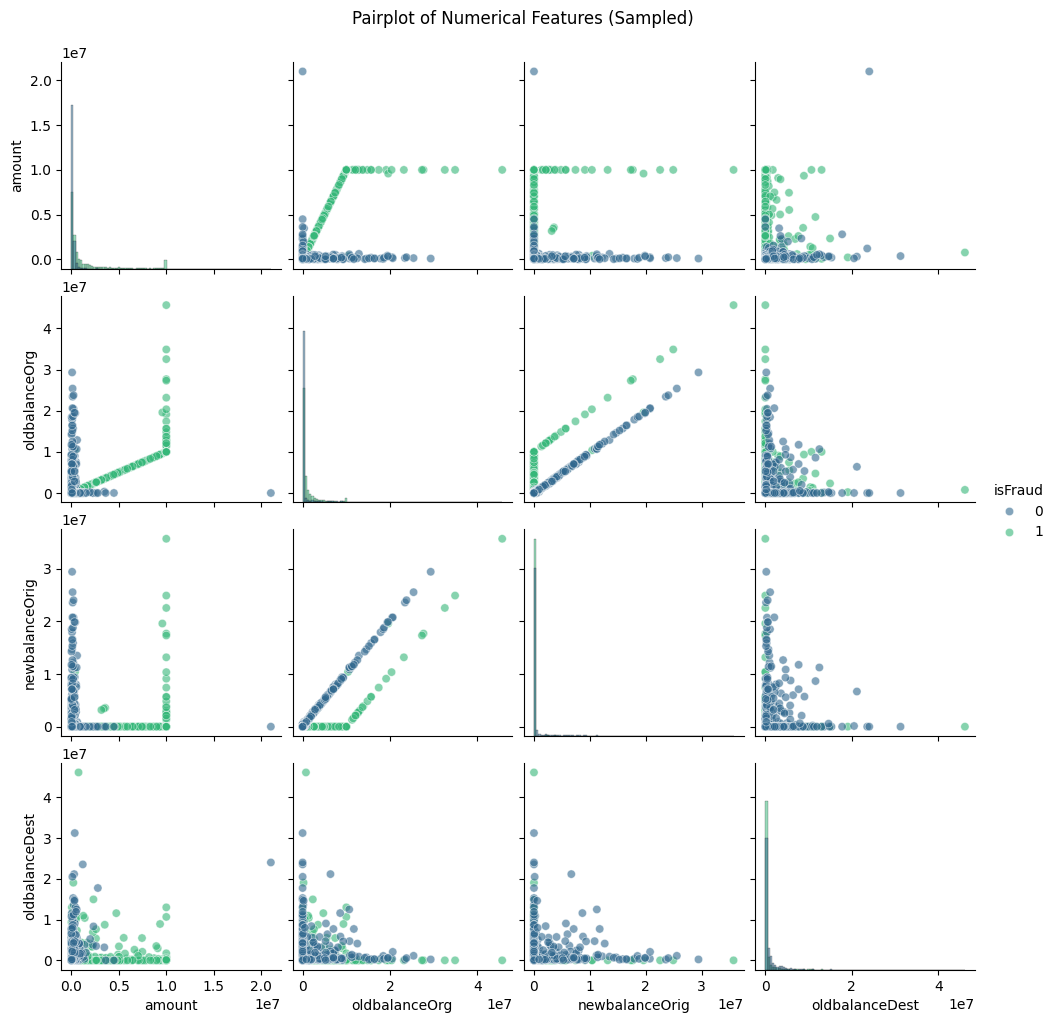

In [36]:
fraud_sample = df[df['isFraud'] == 1].sample(min(1000, len(df[df['isFraud'] == 1])))
non_fraud_sample = df[df['isFraud'] == 0].sample(min(1000, len(fraud_sample)))

sample_df = pd.concat([fraud_sample, non_fraud_sample])

plt.figure(figsize=(12, 10))
sns.pairplot(sample_df, vars=numeric_features[:4], hue='isFraud', 
             diag_kind='hist', palette='viridis', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Numerical Features (Sampled)', y=1.02)
plt.show()

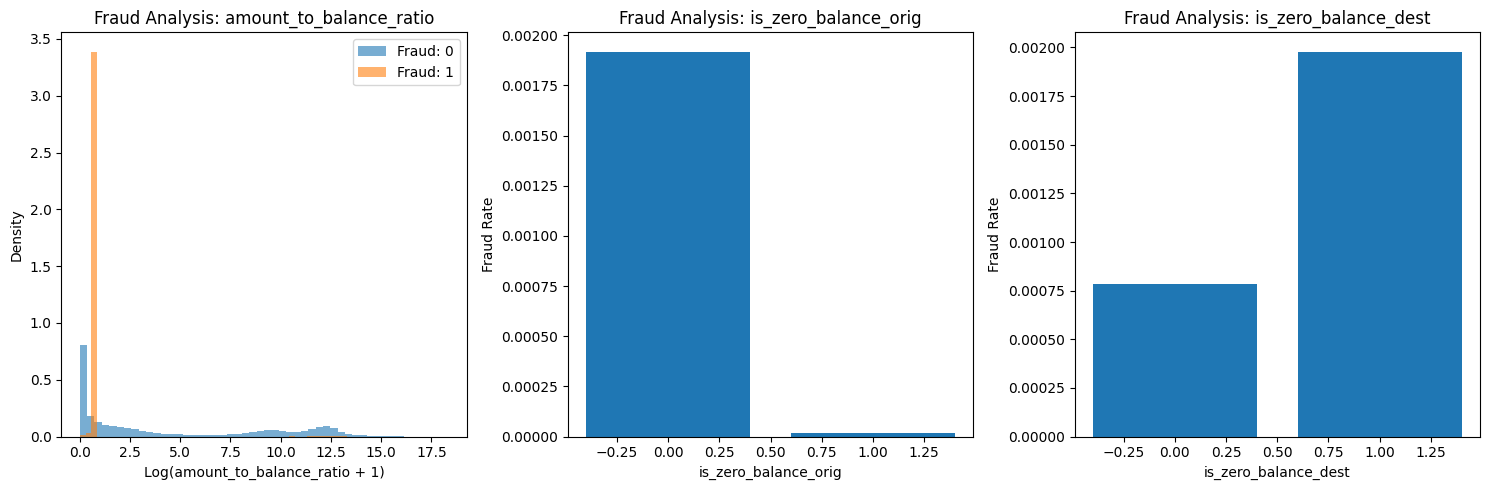

In [37]:
df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['is_zero_balance_orig'] = (df['oldbalanceOrg'] == 0).astype(int)
df['is_zero_balance_dest'] = (df['oldbalanceDest'] == 0).astype(int)

patterns_to_analyze = [
    'amount_to_balance_ratio',
    'is_zero_balance_orig',
    'is_zero_balance_dest'
]
plt.figure(figsize=(15, 5))

for i, pattern in enumerate(patterns_to_analyze, 1):
    plt.subplot(1, 3, i)
    
    if 'ratio' in pattern:
        # Log scale for ratios
        for fraud_status in [0, 1]:
            subset = df[df['isFraud'] == fraud_status][pattern]
            plt.hist(np.log1p(subset), bins=50, alpha=0.6, 
                     label=f'Fraud: {fraud_status}', density=True)
        plt.xlabel(f'Log({pattern} + 1)')
    else:
        fraud_rates = df.groupby(pattern)['isFraud'].mean()
        plt.bar(fraud_rates.index, fraud_rates.values)
        plt.xlabel(pattern)
    
    plt.ylabel('Density' if 'ratio' in pattern else 'Fraud Rate')
    plt.title(f'Fraud Analysis: {pattern}')
    if 'ratio' in pattern:
        plt.legend()

plt.tight_layout()
plt.show()


In [38]:
print("Comparison of Flagged Fraud vs Actual Fraud:")
confusion_matrix = pd.crosstab(df['isFlaggedFraud'], df['isFraud'])
print(confusion_matrix)

precision = confusion_matrix.loc[1, 1] / confusion_matrix.loc[1].sum() if 1 in confusion_matrix.index else 0 # type: ignore
recall = confusion_matrix.loc[1, 1] / confusion_matrix.loc[:, 1].sum() if 1 in confusion_matrix.index else 0
print(f"\nFlagged Fraud Precision: {precision:.2%}")
print(f"Flagged Fraud Recall: {recall:.2%}")

Comparison of Flagged Fraud vs Actual Fraud:
isFraud               0     1
isFlaggedFraud               
0               6354407  8197
1                     0    16

Flagged Fraud Precision: 100.00%
Flagged Fraud Recall: 0.19%


In [39]:
from scipy.stats import mannwhitneyu, chi2_contingency

# Statistical tests for significant differences
print("=== STATISTICAL SIGNIFICANCE TESTS ===")

# Test 1: Amount difference between fraud and non-fraud
fraud_amounts = df[df['isFraud'] == 1]['amount']
non_fraud_amounts = df[df['isFraud'] == 0]['amount']
stat, p_value = mannwhitneyu(fraud_amounts, non_fraud_amounts)
print(f"Amount difference (Mann-Whitney U): p-value = {p_value:.2e}")

# Test 2: Transaction type and fraud association
contingency_table = pd.crosstab(df['type'], df['isFraud'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Transaction type association (Chi-square): p-value = {p_value:.2e}")

# Key business insights summary
print("\n=== KEY BUSINESS INSIGHTS ===")
print(f"1. Overall fraud rate: {df['isFraud'].mean():.2%}")
print(f"2. Most common fraud type: {fraud_by_type.index[0]} ({fraud_by_type.iloc[0]:.2%} fraud rate)")
print(f"3. Peak fraud hour: {fraud_by_hour.idxmax()} ({fraud_by_hour.max():.2%} fraud rate)")
print(f"4. Average fraud transaction amount: ${fraud_amounts.median():.2f}")
print(f"5. Fraud detection system recall: {recall:.2%}")

# Risk factors identification
print("\n=== IDENTIFIED RISK FACTORS ===")
risk_factors = []
if fraud_by_type.max() > 0.1:
    risk_factors.append(f"High fraud concentration in {fraud_by_type.index[0]} transactions")
if fraud_by_hour.max() > fraud_by_hour.median() * 2:
    risk_factors.append(f"Temporal clustering of fraud during hour {fraud_by_hour.idxmax()}")
if df['amount_to_balance_ratio'].max() > 10:
    risk_factors.append("Large transactions relative to account balance")

for i, factor in enumerate(risk_factors, 1):
    print(f"{i}. {factor}")

=== STATISTICAL SIGNIFICANCE TESTS ===
Amount difference (Mann-Whitney U): p-value = 0.00e+00
Transaction type association (Chi-square): p-value = 0.00e+00

=== KEY BUSINESS INSIGHTS ===
1. Overall fraud rate: 0.13%
2. Most common fraud type: TRANSFER (0.77% fraud rate)
3. Peak fraud hour: 5 (22.30% fraud rate)
4. Average fraud transaction amount: $441423.44
5. Fraud detection system recall: 0.19%

=== IDENTIFIED RISK FACTORS ===
1. Temporal clustering of fraud during hour 5
2. Large transactions relative to account balance


In [40]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  hour  \
0  M1979787155             0.0             0.0        0               0     1   
1  M2044282225             0.0             0.0        0               0     1   
2   C553264065             0.0             0.0        1               0     1   
3    C38997010         21182.0             0.0        1               0     1   
4  M1230701703             0.0             0.0        0               0     1   

   day  is_weekend  balance_change_org  balance_change_dest  orig_txn_count  \
0    0           0            -9839.64                  0.0               1   
1    0           0            -1864.28                  0.0               1   
2    0           0             -181.00                  0.0               1   
3    0           0             -181.00             -21182.0               1   
4    0           0           -11668.14                  0.0               1   

   amount_to_balance_ratio  is_zero_balance_orig  is_zero_balance_dest  
0                 0.057834                     0                     1  
1                 0.087731                     0                     1  
2                 0.994505                     0                     1  
3                 0.994505                     0                     0  
4                 0.280788                     0                     1

In [41]:
import os
os.makedirs('processeddataset', exist_ok=True)

In [42]:
df.to_csv('processeddataset/processed_paySim.csv', index=False)